# Transfer learning   
### Based on:   
https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

In [1]:
import sys
import numpy as np
import h5py
import copy
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


## Read data. Make train and test sets

In [3]:
def readScan(scanName,var_name):
    data=h5py.File(scanName,'r')
    Xscans=data.get(var_name)
    X=copy.copy(Xscans.value)
    X1=np.rollaxis(X,0,start=3)
    return X1

In [4]:
n_echoes=100
skip_rows=3 # the first 50 description files have a different format 

X_rest=[]
X_stress=[]
X_reserve=[]
y=[]

for idx,i in enumerate(np.arange(n_echoes)+1):
    scan_rest='../stress_rest_reserve_100/rest{0}.mat'.format(i)
    X_rest.append(readScan(scan_rest,'rest'))
    scan_stress='../stress_rest_reserve_100/stress{0}.mat'.format(i)
    X_stress.append(readScan(scan_stress,'stress'))
    scan_reserve='../stress_rest_reserve_100/reserve{0}.mat'.format(i)
    X_reserve.append(readScan(scan_reserve,'reserve'))
    # the first 50 description files have a different format 
    if i==51:
        skip_rows=0
    labels=pd.read_csv('../Data100/PD_ANN0%03d.csv' % (i), skiprows=skip_rows)
    # Criteria to determine whether a polar map does not have risk = 0 or has risk = 1
    LAD=labels['Reserve mean'][0]
    LCX=labels['Reserve mean'][1]
    RCA=labels['Reserve mean'][2]
    y_temp=[0 if LAD > 2 and LCX > 2 and RCA > 2 else 1]
    y.append(y_temp[0])

In [5]:
train_test_ratio=.7
train_size=int(n_echoes*train_test_ratio)
rand_samples=random.sample(range(0,n_echoes),n_echoes)

In [6]:
# permute the samples
X_rest=[X_rest[i] for i in rand_samples]
X_stress=[X_stress[i] for i in rand_samples]
X_reserve=[X_reserve[i] for i in rand_samples]
y=[y[i] for i in rand_samples]

In [7]:
# Format for keras
X_rest=np.array(X_rest)
X_stress=np.array(X_stress)
X_reserve=np.array(X_reserve)
from keras.utils import to_categorical
y=np.array(y)
y=to_categorical(y, num_classes=2)

In [8]:
np.sum(y,0)

array([ 64.,  36.])

---

## Add padding to match inception shape

In [108]:
## size for VGG = 224
## size for inception = 299

In [9]:
def match_base_model_size(X,network='VGG'):
    """
    Function does not generalize, made only for specific dimensions size
    """
    pixels_base_model=[224 if network=='VGG' else 299]
    ## For VGG
    if int(pixels_base_model[0])-np.shape(X)[1]==1:
        print('VGG')
        pixels_to_add=1
        padding=((0,pixels_to_add),(0,pixels_to_add),(0,0))
        X=[np.pad(i,padding,mode='constant', constant_values=0) for i in X]
    ## For Inception
    elif int((pixels_base_model[0])-np.shape(X)[1])>=2:
        pixels_to_add=int(((pixels_base_model[0])-np.shape(X)[1])/2)
        print('Inception')
        padding=((pixels_to_add,pixels_to_add),(pixels_to_add,pixels_to_add),(0,0))
        X=[np.pad(i,padding,mode='constant', constant_values=0) for i in X]
    else:
        print('check dimensions') 
    return(np.array(X))

In [10]:
X_rest=match_base_model_size(X_rest,'VGG')
X_stress=match_base_model_size(X_stress,'VGG')
X_reserve=match_base_model_size(X_reserve,'VGG')

VGG
VGG
VGG


(224, 224)


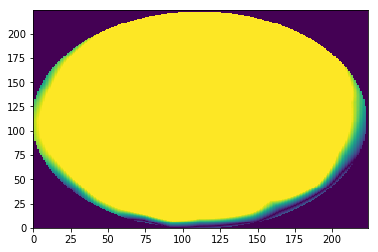

In [11]:
plt.pcolor(X_rest[5][:,:,1])
print(np.shape(X_rest[5][:,:,1]))

# Get pretrained model

In [38]:
# base_model = applications.InceptionV3(weights='imagenet', include_top=False)

87851008/87910968 [============================>.] - ETA: 0s

In [92]:
# base_model = applications.VGG19(weights = "imagenet", include_top=False)

80019456/80134624 [============================>.] - ETA: 0s

In [39]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# serialize model to JSON
# model_json = base_model.to_json()
# with open("model_InceptionV3.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# base_model.save_weights("model_InceptionV3.h5")
# print("Saved model to disk")

Saved model to disk


In [36]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# load json and create model
from keras.models import model_from_json
json_file = open('model_VGG19.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
base_model = model_from_json(loaded_model_json)
# load weights into new model
base_model.load_weights("model_VGG19.h5")
print("Loaded model from disk")

Loaded model from disk


---

# Functions   
https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine-tune.py

In [37]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.00001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [38]:
# https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet
  Args:
    base_model: keras model excluding top
    nb_classes: # of classes
  Returns:
    new keras model with last layer
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) 
  predictions = Dense(nb_classes, activation='softmax')(x) 
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [39]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='Adam',    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [40]:
def setup_to_finetune(model,learning_rate):
   """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top 
      layers.
   note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in 
         the inceptionv3 architecture
   Args:
     model: keras model
   """
   for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
      layer.trainable = False
   for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
      layer.trainable = True
   model.compile(optimizer=SGD(lr=learning_rate, momentum=0.9),   
                 loss='categorical_crossentropy',
                metrics=['accuracy'])

In [41]:
np.shape(X_rest)

(100, 224, 224, 3)

---

In [42]:
nb_classes=2
FC_SIZE = 1024
NB_EPOCHS = 30
BAT_SIZE = 32
NB_IV3_LAYERS_TO_FREEZE = 172

In [43]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [44]:
# setup model
model = add_new_last_layer(base_model, nb_classes)

In [45]:
# transfer learning
setup_to_transfer_learn(model, base_model)

In [ ]:
history_tl=model.fit(np.array(X_rest),y,batch_size=BAT_SIZE,
                  epochs=NB_EPOCHS,shuffle=True,
                    validation_split=.2,
                    callbacks=callbacks_list,
                    verbose=2)

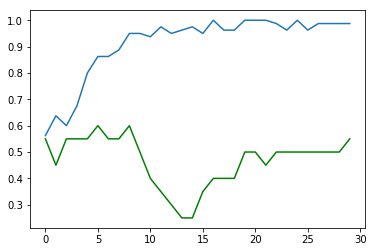

In [51]:
plt.plot(history_tl.history['acc'])
plt.plot(history_tl.history['val_acc'],'g')

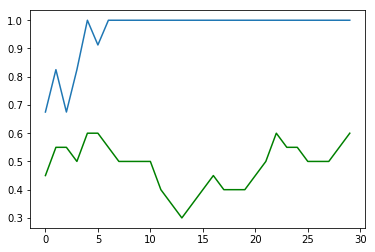

In [41]:
plt.plot(history_tl.history['acc'])
plt.plot(history_tl.history['val_acc'],'g')

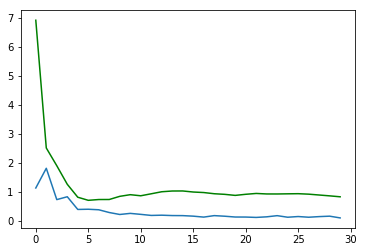

In [52]:
plt.plot(history_tl.history['loss'])
plt.plot(history_tl.history['val_loss'],'g')

In [43]:
learning_rate=k.get_value(model.optimizer.lr)

In [44]:
 # fine-tuning
setup_to_finetune(model,learning_rate)

In [53]:
history_ft=model.fit(X,y,batch_size=BAT_SIZE,
                  epochs=5,shuffle=True,
                    validation_split=.2)

Train on 80 samples, validate on 20 samples
Epoch 1/5
80/80 [==============================] - 35s - loss: 0.1191 - acc: 0.9875 - val_loss: 0.7852 - val_acc: 0.6000
Epoch 2/5
80/80 [==============================] - 34s - loss: 0.1220 - acc: 0.9625 - val_loss: 0.8287 - val_acc: 0.5500
Epoch 3/5
80/80 [==============================] - 34s - loss: 0.1291 - acc: 0.9875 - val_loss: 0.8944 - val_acc: 0.5000
Epoch 4/5
80/80 [==============================] - 34s - loss: 0.1338 - acc: 0.9750 - val_loss: 0.9026 - val_acc: 0.5000
Epoch 5/5
80/80 [==============================] - 35s - loss: 0.1208 - acc: 0.9875 - val_loss: 0.8754 - val_acc: 0.5500


In [67]:
def plot_training(history_tl,history_ft):
  acc = history_tl.history['acc']+history_ft.history['acc']
  val_acc = history_tl.history['val_acc']+history_ft.history['val_acc']
  loss = history_tl.history['loss']+history_ft.history['loss']
  val_loss = history_tl.history['val_loss']+history_ft.history['val_loss']
  epochs = range(len(acc))
  epochs_tl=len(history_tl.history['acc'])

  plt.plot(epochs, acc, 'b')
  plt.plot(epochs, val_acc, 'g')
  plt.title('Training and validation accuracy')
  plt.vlines(epochs_tl,0,1,linestyle='--')

  plt.figure()
  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'g')
  plt.title('Training and validation loss')
plt.show()

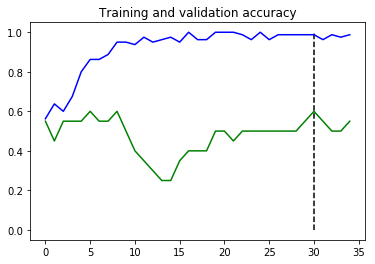

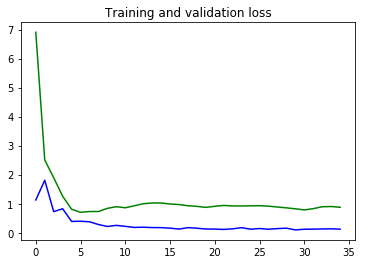

In [68]:
plot_training(history_tl,history_ft)

In [71]:
np.sum(y[80:],0)

array([ 11.,   9.])

In [72]:
np.sum(y,0)

array([ 64.,  36.])